In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.stats.diagnostic import het_arch

In [2]:
datos_cartera=pd.read_csv('Datos/Transformados/cartera.csv', index_col=[0], parse_dates=[0])
datos_cartera.head()

,AAPL,CAT,MSFT
fecha,,,
2018-06-07,48.37500,156.289993,100.879997
2018-06-08,47.87750,155.320007,101.629997
2018-06-11,47.79000,156.350000,101.050003
2018-06-12,48.08000,157.485000,101.309998
2018-06-13,47.66625,154.700000,100.849998


In [ ]:
# corr_pearson = datos_cartera.corr(method="pearson")

In [ ]:
# fig, ax =plt.subplots(1,1, figsize=(10,10))

# sns.heatmap(corr_pearson, annot=True,vmin=-1, vmax=1, center=0,cmap=sns.diverging_palette(20, 220, n=200),square=True, ax=ax)
# ax.set_xticklabels(ax.get_xticklabels(),rotation=45,horizontalalignment='right')
# ax.set_yticklabels(ax.get_yticklabels(),rotation=0,horizontalalignment='right')
# ax.set_title("Spearman Correlation Matrix");

### AAPL

<Axes: xlabel='fecha'>

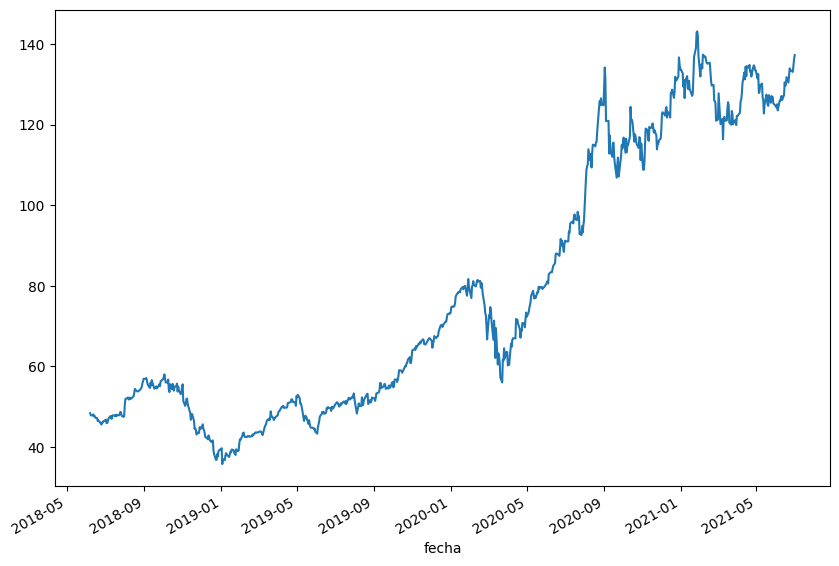

In [3]:
datos_cartera['AAPL'].plot(figsize=(10,7))

In [4]:
datos_cartera['AAPL'].isna().sum()

np.int64(0)

In [5]:
datos_cartera['AAPL'].dtype

dtype('float64')

In [6]:
datos_cartera['AAPL'].resample('Y').count()

C:\Users\PORTATIL\AppData\Local\Temp\ipykernel_9520\825100696.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  datos_cartera['AAPL'].resample('Y').count()


fecha
2018-12-31    148
2019-12-31    261
2020-12-31    261
2021-12-31    127
Freq: YE-DEC, Name: AAPL, dtype: int64

ESTACIONALIDAD

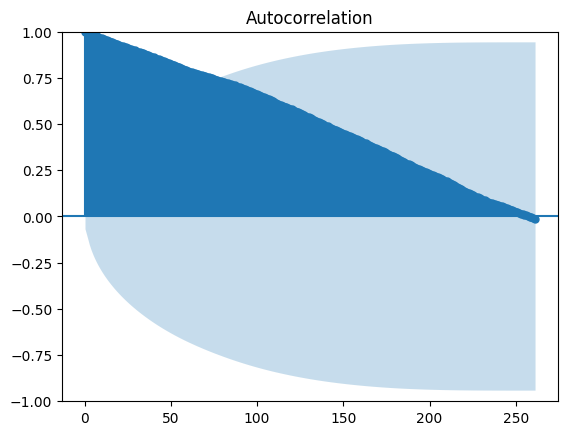

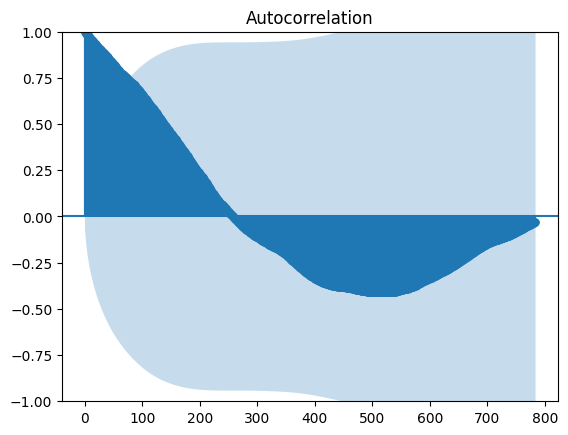

In [7]:
from statsmodels.graphics import tsaplots
tsaplots.plot_acf(datos_cartera['AAPL'], lags=261);
tsaplots.plot_acf(datos_cartera['AAPL'], lags=(261*3));

Como no es una series estacional, no hay que sacar el residuo mediante la descomposición. 
Para conseguir el residuo, hay que restar la tendencia a la serie original.

TENDENCIA

<Axes: xlabel='fecha'>

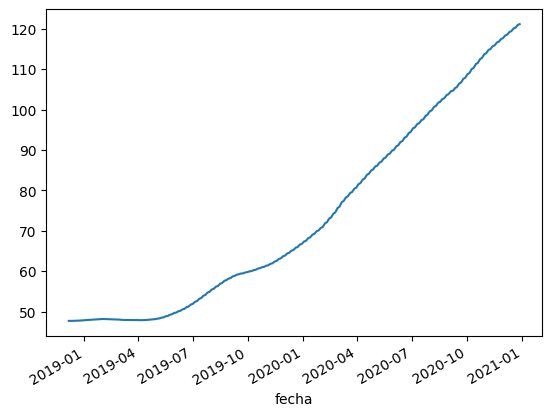

In [8]:
decomposicion_aapl=seasonal_decompose(datos_cartera['AAPL'], model='multiplicative', period=261)
trend=decomposicion_aapl.trend
trend.dropna(inplace=True)
trend.plot()

In [9]:
datos_cartera['resido_AAPLE'] = datos_cartera['AAPL'] - trend
datos_cartera['resido_AAPLE'].dropna(inplace=True)
datos_cartera.head()

,AAPL,CAT,MSFT,resido_AAPLE
fecha,,,,
2018-06-07,48.37500,156.289993,100.879997,NaN
2018-06-08,47.87750,155.320007,101.629997,NaN
2018-06-11,47.79000,156.350000,101.050003,NaN
2018-06-12,48.08000,157.485000,101.309998,NaN
2018-06-13,47.66625,154.700000,100.849998,NaN


<Axes: xlabel='fecha'>

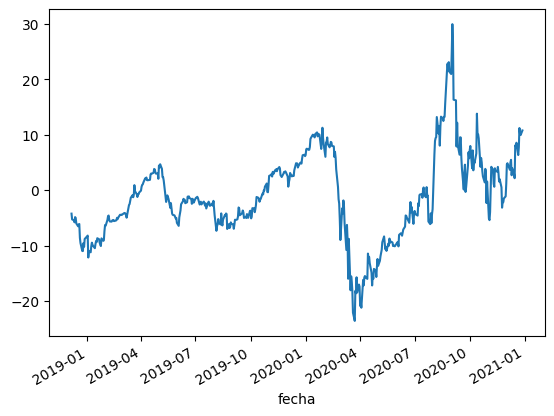

In [10]:
datos_cartera['resido_AAPLE'].plot()

In [11]:
def test_estacionario(residuo):

    residuo=residuo.dropna()
    adf_test = adfuller(residuo, autolag='AIC')
    p_adf = adf_test[1]

    kpss_test = kpss(residuo, nlags="auto")
    p_kpss = kpss_test[1]

    arch_test = het_arch(residuo)
    p_arch = arch_test[1]

    if p_adf < 0.05 and p_kpss > 0.05:
        estacionario = "La serie es ESTACIONARIA"
    else:
        estacionario = "La serie NO es estacionaria"

    if p_arch < 0.05:
        heterocedasticidad = "Existe HETEROCEDASTICIDAD (varianza no constante)"
    else:
        heterocedasticidad = "No hay heterocedasticidad (varianza constante)"

    resultados = {
        'ADF_pvalue': p_adf,
        'KPSS_pvalue': p_kpss,
        'ARCH_pvalue': p_arch,
        'Conclusión_estacionariedad': estacionario,
        'Conclusión_heterocedasticidad': heterocedasticidad
    }
    
    return resultados

In [12]:
test_aapl=test_estacionario(datos_cartera['resido_AAPLE'])
test_aapl

{'ADF_pvalue': np.float64(0.22849989581876595),
 'KPSS_pvalue': np.float64(0.06546031163641847),
 'ARCH_pvalue': np.float64(8.515958552554994e-90),
 'Conclusión_estacionariedad': 'La serie NO es estacionaria',
 'Conclusión_heterocedasticidad': 'Existe HETEROCEDASTICIDAD (varianza no constante)'}

<Axes: xlabel='fecha'>

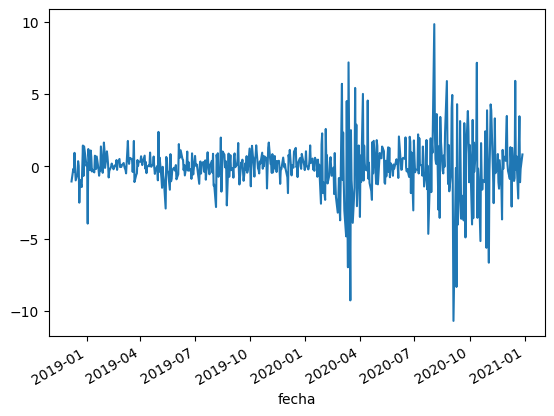

In [13]:
diff_apple=datos_cartera['resido_AAPLE'].diff()
datos_cartera['resido_AAPLE2']=diff_apple
datos_cartera['resido_AAPLE2'].plot()

In [ ]:
test_estacionario(diff_apple)

C:\Users\PORTATIL\AppData\Local\Temp\ipykernel_9520\3505837973.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = kpss(residuo, nlags="auto")


{'ADF_pvalue': 0.0,
 'KPSS_pvalue': np.float64(0.1),
 'ARCH_pvalue': np.float64(7.194604036065928e-15),
 'Conclusión_estacionariedad': 'La serie es ESTACIONARIA',
 'Conclusión_heterocedasticidad': 'Existe HETEROCEDASTICIDAD (varianza no constante)'}

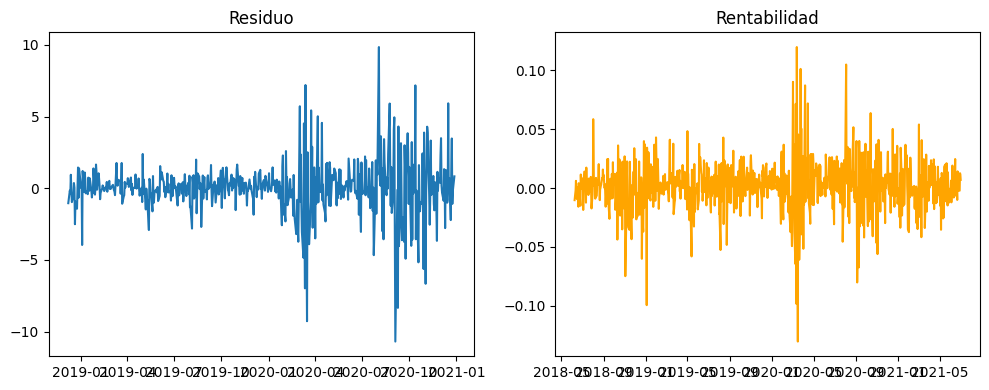

In [15]:
datos_cartera['rent_apple'] = datos_cartera['AAPL'].pct_change()
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].plot(datos_cartera['resido_AAPLE2'])
axes[0].set_title("Residuo")

axes[1].plot(datos_cartera['rent_apple'], color='orange')
axes[1].set_title("Rentabilidad")

plt.tight_layout()  
plt.show()

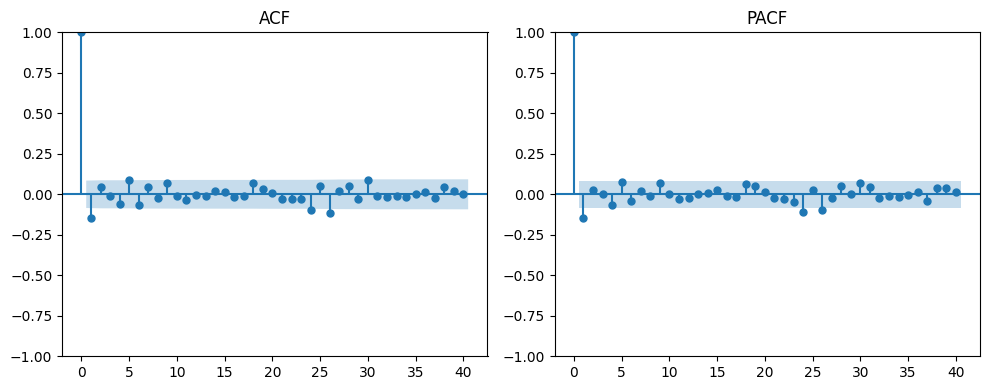

In [16]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

plot_acf(datos_cartera['resido_AAPLE2'].dropna(), lags=40, ax=axes[0])
axes[0].set_title("ACF")

plot_pacf(datos_cartera['resido_AAPLE2'].dropna(), lags=40, ax=axes[1])
axes[1].set_title("PACF")

plt.tight_layout()
plt.show()


In [17]:
# GARCH(2,2)
from arch import arch_model
garchm = arch_model(datos_cartera['resido_AAPLE2'].dropna(), p = 2, q = 2, o=1,
                      mean = 'constant', vol = 'EGARCH')
gm_result = garchm.fit(update_freq = 4)

Iteration:      4,   Func. Count:     44,   Neg. LLF: 9692450021.514914
Iteration:      8,   Func. Count:     84,   Neg. LLF: 902.8073552972553
Iteration:     12,   Func. Count:    120,   Neg. LLF: 896.4773327023615
Iteration:     16,   Func. Count:    153,   Neg. LLF: 896.4233954024045
Iteration:     20,   Func. Count:    188,   Neg. LLF: 896.4231685696201
Optimization terminated successfully    (Exit mode 0)
            Current function value: 896.4231620478371
            Iterations: 21
            Function evaluations: 197
            Gradient evaluations: 21


In [18]:
print(gm_result.summary())

                     Constant Mean - EGARCH Model Results                     
Dep. Variable:          resido_AAPLE2   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -896.423
Distribution:                  Normal   AIC:                           1806.85
Method:            Maximum Likelihood   BIC:                           1836.84
                                        No. Observations:                  536
Date:               lu., oct. 20 2025   Df Residuals:                      535
Time:                        11:36:34   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.1255  9.197e-04    136.411      0.000 [  0.124,  0.12

In [19]:
test_estacionario(gm_result.std_resid)

C:\Users\PORTATIL\AppData\Local\Temp\ipykernel_9520\3505837973.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = kpss(residuo, nlags="auto")


{'ADF_pvalue': 0.0,
 'KPSS_pvalue': np.float64(0.1),
 'ARCH_pvalue': np.float64(0.8543927605388071),
 'Conclusión_estacionariedad': 'La serie es ESTACIONARIA',
 'Conclusión_heterocedasticidad': 'No hay heterocedasticidad (varianza constante)'}

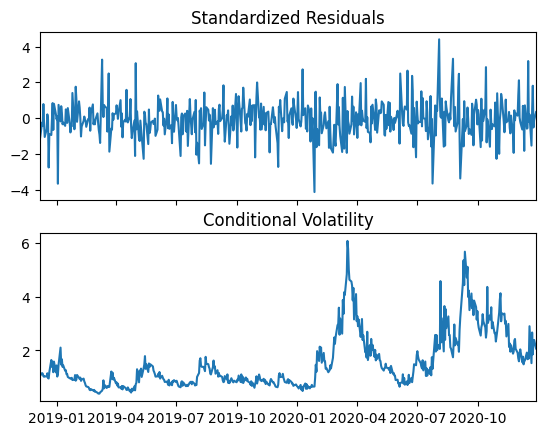

In [20]:
gm_result.plot()
plt.show()

### MSFT

<Axes: xlabel='fecha'>

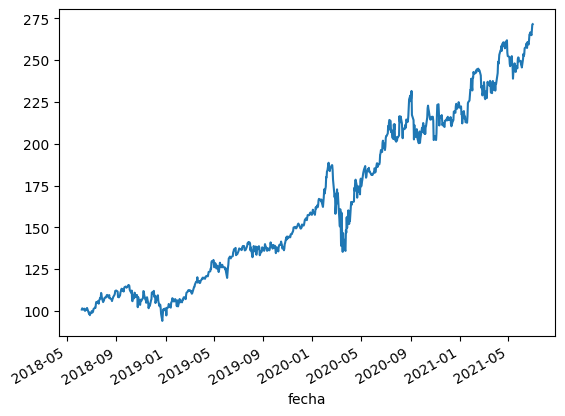

In [21]:
datos_cartera['MSFT'].plot()

In [22]:
datos_cartera['MSFT'].isna().sum()

np.int64(0)

In [23]:
datos_cartera['MSFT'].resample('Y').count()

C:\Users\PORTATIL\AppData\Local\Temp\ipykernel_9520\1920217640.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  datos_cartera['MSFT'].resample('Y').count()


fecha
2018-12-31    148
2019-12-31    261
2020-12-31    261
2021-12-31    127
Freq: YE-DEC, Name: MSFT, dtype: int64

ESTACIONALIDAD

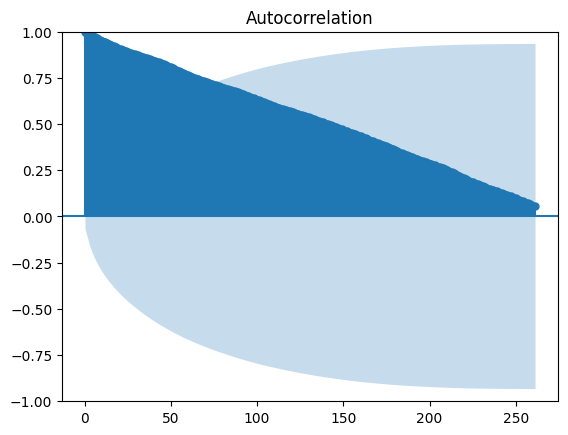

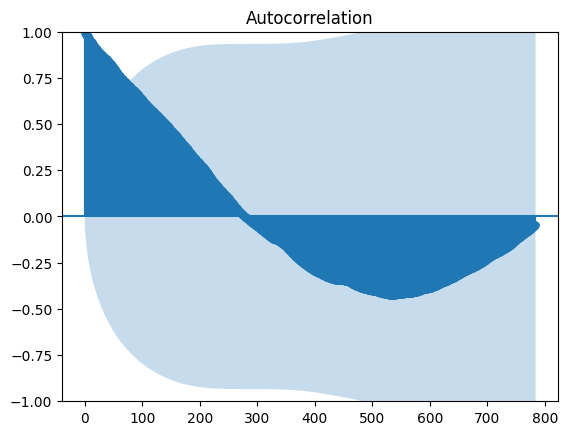

In [24]:
from statsmodels.graphics import tsaplots
tsaplots.plot_acf(datos_cartera['MSFT'], lags=261);
tsaplots.plot_acf(datos_cartera['MSFT'], lags=(261*3));

Como no es una series estacional, no hay que sacar el residuo mediante la descomposición. 
Para conseguir el residuo, hay que restar la tendencia a la serie original.

TENDENCIA

In [29]:
datos_cartera['residuo_MSFT'] = datos_cartera['MSFT'].diff()

<Axes: xlabel='fecha'>

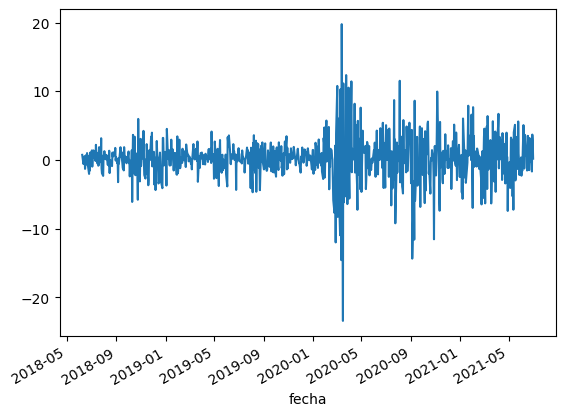

In [30]:
datos_cartera['residuo_MSFT'].plot()

In [31]:
# decomposicion_msft = seasonal_decompose(datos_cartera["MSFT"], model='multiplicative', period=261)
# trend_msft=decomposicion_msft.trend
# trend_msft.dropna(inplace=True)
# trend_msft.plot()

In [32]:
# datos_cartera['residuo_MSFT'] = datos_cartera['MSFT'] - trend_msft
# datos_cartera['residuo_MSFT'].dropna(inplace=True)
# datos_cartera.head()

In [33]:
test_estacionario(datos_cartera['residuo_MSFT'])

C:\Users\PORTATIL\AppData\Local\Temp\ipykernel_9520\3505837973.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = kpss(residuo, nlags="auto")


{'ADF_pvalue': np.float64(7.756230692136409e-14),
 'KPSS_pvalue': np.float64(0.1),
 'ARCH_pvalue': np.float64(3.3196327917578183e-49),
 'Conclusión_estacionariedad': 'La serie es ESTACIONARIA',
 'Conclusión_heterocedasticidad': 'Existe HETEROCEDASTICIDAD (varianza no constante)'}

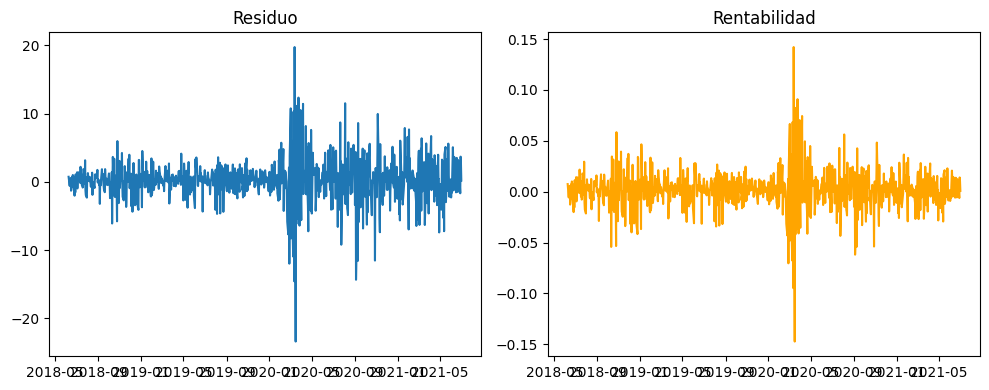

In [34]:
datos_cartera['rent_msft'] = datos_cartera['MSFT'].pct_change()
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].plot(datos_cartera['residuo_MSFT'])
axes[0].set_title("Residuo")

axes[1].plot(datos_cartera['rent_msft'], color='orange')
axes[1].set_title("Rentabilidad")

plt.tight_layout()  
plt.show()

GARCH

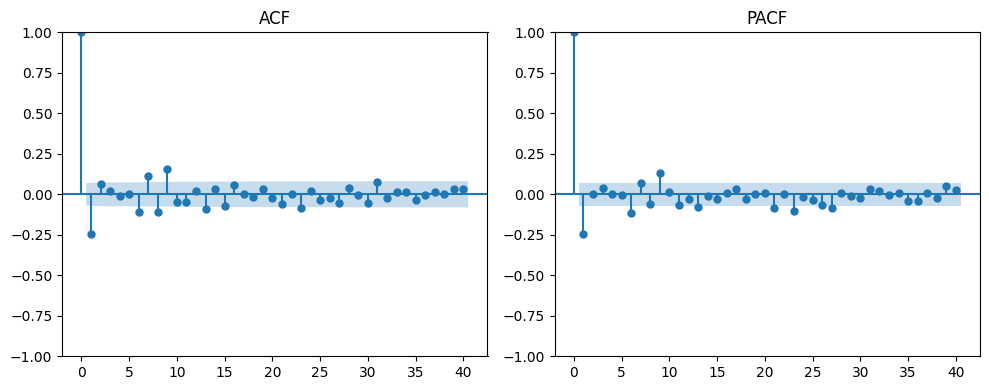

In [36]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

plot_acf(datos_cartera['residuo_MSFT'].dropna(), lags=40, ax=axes[0])
axes[0].set_title("ACF")

plot_pacf(datos_cartera['residuo_MSFT'].dropna(), lags=40, ax=axes[1])
axes[1].set_title("PACF")

plt.tight_layout()
plt.show()

In [37]:
from arch import arch_model
modelo_garch = arch_model(datos_cartera['residuo_MSFT'].dropna(), vol='EGARCH', p=2, q=2, dist='normal')
resultado_garch = modelo_garch.fit(update_freq=5, disp='off')
print(resultado_garch.summary())


                     Constant Mean - EGARCH Model Results                     
Dep. Variable:           residuo_MSFT   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -1831.29
Distribution:                  Normal   AIC:                           3674.57
Method:            Maximum Likelihood   BIC:                           3702.65
                                        No. Observations:                  796
Date:               lu., oct. 20 2025   Df Residuals:                      795
Time:                        11:42:59   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.2311  6.154e-02      3.755  1.735e-04 [  0.110,  0.35

In [38]:
test_estacionario(resultado_garch.std_resid)

C:\Users\PORTATIL\AppData\Local\Temp\ipykernel_9520\3505837973.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = kpss(residuo, nlags="auto")


{'ADF_pvalue': 0.0,
 'KPSS_pvalue': np.float64(0.1),
 'ARCH_pvalue': np.float64(0.29642784498806235),
 'Conclusión_estacionariedad': 'La serie es ESTACIONARIA',
 'Conclusión_heterocedasticidad': 'No hay heterocedasticidad (varianza constante)'}

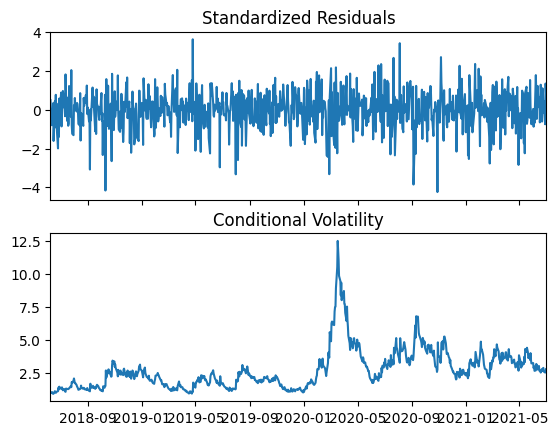

In [40]:
resultado_garch.plot()
plt.show()